# Salesforce Data Analytics
## This notebook is divided into two parts:
- **PostgreSQL** Connection setup and a Use Case \
    a. Find the products involved in the Case using the Case Subject and Description
- **Neo4j** Connection setup and Use Cases \
    a. Sum of Opportunities Booking Amount \
    b. Account and their Parents \
    c. Total Number of cases \
    d. Open Cases per account \
    e. Products having most cases \
    f. Customer Cases and Priority
- Here is the github repository [Salesforce-Data-Analytics](https://github.com/skhire29/sales-data-analytics "Salesforce-data-analytics")

# PostgreSQL
### Creating a connection with postgreSQL

In [133]:
import psycopg2
import pandas as pd
def init_connection():
    return psycopg2.connect(dbname="salesforce_db", user="***", password="***")

## Find the products involved in the Case using the Case Subject and description

In [137]:
conn = init_connection()
get_products = f"""
select array_agg(distinct product_name) from sales_service_cloud.product
union all
select distinct array_agg(distinct product_family) from sales_service_cloud.product;
"""

def run_query(query):
    with conn.cursor() as cur:
        cur.execute(query)
        colnames = [desc[0] for desc in cur.description]
        return colnames, cur.fetchall()

col, rows = run_query(get_products)
products = rows[0][0]
regex_product = '(' + '|'.join(products) + ')'
regex_product = regex_product.lower()

# print(regex_product)
    
query = f"""
select 
      c.case_id
    , c.subject
    , c.description
    , (regexp_match(lower(description),'{regex_product}'))[1] as identified_product_from_description
    , (regexp_match(lower(subject),'{regex_product}'))[1] as identified_product_from_subject
    , string_to_array(trim(
        coalesce((regexp_match(lower(description),'{regex_product}'))[1], '') 
        ||  ',' || 
        coalesce((regexp_match(lower(subject),'{regex_product}'))[1],'')
        ,','),
     ',') as identified_products_with_problems

from sales_service_cloud.case as c

"""
# print(query)
col, rows = run_query(query)
dataframe = pd.DataFrame(rows, columns=col)
conn.close()

In [138]:
dataframe

,case_id,subject,description,identified_product_from_description,identified_product_from_subject,identified_products_with_problems
0,5005h00000fu6mkAAA,Pump Motor has serious breakdown issues.,Pump Motor keeps breaking down on a regular ba...,pump motor,pump motor,"[pump motor, pump motor]"
1,5005h00000fu6JLAAY,Axle wheel broken,Axle is damaged with broken internal wheel. Re...,axle,axle,"[axle, axle]"
2,5005h00000fu6NDAAY,Frequent breakdown issue with the pump motor,Pump motor keeps breaking-down frequently even...,pump motor,pump motor,"[pump motor, pump motor]"
3,5005h00000fu6qyAAA,Pump casing has performance serious issues.,The new installed pump casing is not a perfect...,pump casing,pump casing,"[pump casing, pump casing]"
4,5005h00000ftxjHAAQ,Pump motor,Motor speed is slowing down after 30 minutes use,None,pump motor,[pump motor]
5,5005h00000fu6WZAAY,Battery Anode breaks down frequently,The new battery anodes that were installed dur...,battery anode,battery anode,"[battery anode, battery anode]"
6,5005h00000fu6qAAAQ,Field magnet does not spin,Magnet is not rotating with the axle.,axle,field magnet,"[axle, field magnet]"
7,5005h00000ftylxAAA,Motor spins much higher than axle threads,Axle threads and motor spins and not compatible,axle,axle,"[axle, axle]"
8,5005h00000ftylyAAA,Spark blug busted,Excessive voltage damaged the plug,None,None,[]
9,5005h00000fu6LvAAI,Complexity issue with Generator spark plug nee...,A crackling noise can be heard and the generat...,None,generator spark plug,[generator spark plug]


In [1]:
from neo4j import GraphDatabase
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
import numpy as np

In [2]:
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("***", "***"))

In [3]:
with driver.session(database = 'neo4j') as session:
    query = "match (a:Account) return count(a.account_id)"
    response = list(session.run(query))
    print(response[0][0])
    print(session)
driver.close()

61


In [6]:
def run_query(query, session):
    response = list(session.run(query))
    return response

In [7]:
session = driver.session(database = 'neo4j')

In [8]:
# Sum of Opportunities Booking Amount
query = f"""
match (a:Account), (o:Opportunity) 
where o.account_id = a.account_id  
return a.account_name, o.name, sum(toFloat(o.amount));
"""
response = run_query(query, session)

In [9]:
# Account and their Parents
query = f"""
    match (a:Account), (p:Account) 
    where p.account_id = a.parent_account_id 
    return 
    a.account_name as account_name, 
    p.account_name as parent_name
"""
response = run_query(query, session)

# Neo4j
## Creating a connection with Neo4j Database

In [20]:
from py2neo import Graph
graph = Graph("bolt://localhost:7687", auth=("***", "***"))

In [21]:
data = graph.run(query)

In [22]:
data

account_name,opportunity_name,total_booking_amount
Edge Communications,Edge Emergency Generator,150000.0
Edge Communications,Edge Installation,56800.0
Edge Communications,Edge SLA,82000.0


In [20]:
df = pd.DataFrame.from_dict(data)

In [23]:
def run_query(query, graph):
    data = graph.run(query).data()
    reeturn pd.DataFrame.from_dict(data)

### Sum of Opportunities Booking Amount

In [24]:
# Sum of Opportunities Booking Amount
query = f"""
match (a:Account), (o:Opportunity) 
where o.account_id = a.account_id  
return 
    a.account_name as account_name, 
    o.name as opportunity_name, 
    sum(toFloat(o.amount)) as total_booking_amount;
"""
run_query(query, graph)

,account_name,opportunity_name,total_booking_amount
0,Edge Communications,Edge Emergency Generator,150000.0
1,Edge Communications,Edge Installation,56800.0
2,Edge Communications,Edge SLA,82000.0
3,United Oil & Gas Corp.,United Oil & Gas Corp. EC-D,43700.0
4,Edge Communications,Edge Communications NC,129000.0
...,...,...,...
175,Express Logistics and Transport,Express Logistics and Transport EC-U,52000.0
176,JD systems,JD systems NC,3500.0
177,Tantheta,System integration,25600.0
178,Drivenow,Drivenow EC-D,35000.0


### Account and their Parents

In [25]:
# Account and their Parents
query = f"""
    match (a:Account), (p:Account) 
    where p.account_id = a.parent_account_id 
    return 
    a.account_name as account_name, 
    p.account_name as parent_name
"""
run_query(query, graph)

,account_name,parent_name
0,"United Oil & Gas, Singapore","United Oils, Inc"
1,"United Oil & Gas, UK","United Oils, Inc"
2,GenePoint,Pine labs
3,Finacle,JSR finance
4,"Google, Inc","Alphabet, Inc"
5,"GB Financials, EMEA",GB Financials
6,Tantheta,Crowe
7,United Oil & Gas Corp.,"United Oils, Inc"


### Total Number of cases

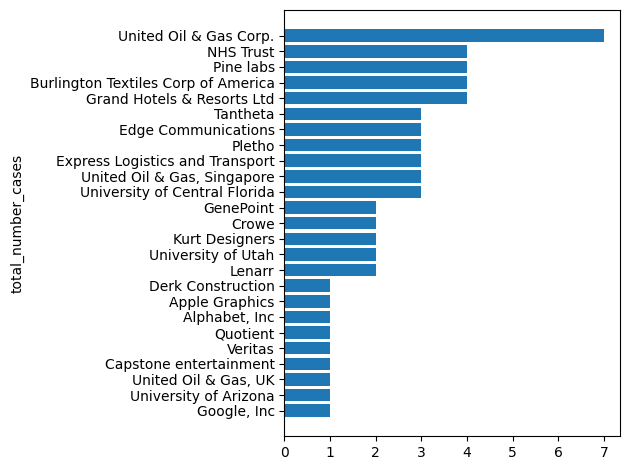

In [57]:
# Total Number of cases
query = f"""
    match (cs:Case), (a:Account) 
    where a.account_id = cs.account_id 
    return 
    a.account_name as account_name, 
    count(cs.case_id) as total_number_cases;
"""

data = run_query(query, graph)
data = data.sort_values('total_number_cases')
total_number_cases = np.array(data['total_number_cases'])
account_names = data['account_name'].values
plt.rcParams["figure.autolayout"] = True
plt.barh(account_names, total_number_cases)
plt.ylabel('total_number_cases')
plt.show()

### Open Cases per account 

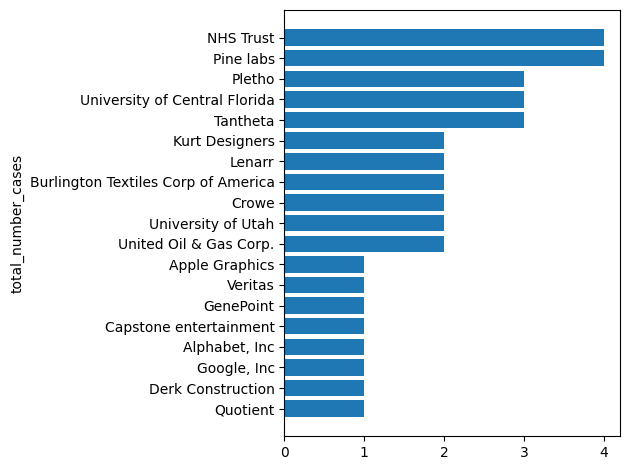

In [25]:
# Open Cases per account
query = """
MATCH (a:Account), (cs:Case) WHERE EXISTS {
  MATCH (a)-[:has_cases]->(cs:Case)
   where cs.closed = 'FALSE'
}
RETURN a.account_name AS account_name, 
       count(cs.case_id) as cases_count 
       order by count(cs.case_id) desc
"""

data = run_query(query, graph)
data
data = data.sort_values('cases_count')
total_number_cases = np.array(data['cases_count'])
account_names = data['account_name'].values
plt.rcParams["figure.autolayout"] = True
plt.barh(account_names, total_number_cases)
plt.ylabel('total_number_cases')
plt.show()

### Products having most cases

['Electric Motor' 'Electric Motor' 'Generator' 'Gear' 'Battery'
 'Electric Motor' 'Gear' 'Generator' 'Battery' 'Battery' 'Electric Motor'
 'Pump' 'Pump']


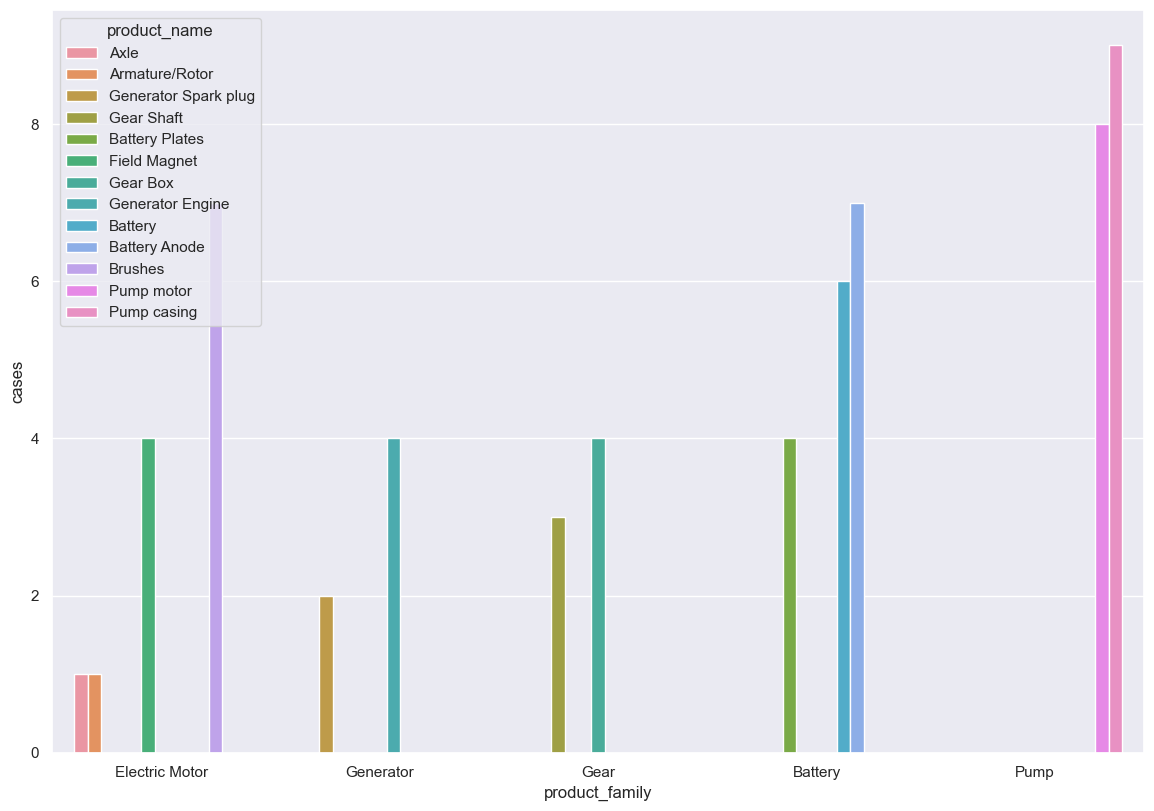

In [81]:
# Products having most cases
import seaborn as sns
query = f"""
    match (p:Product), (cs:Case) 
    where cs.product2 = p.product_id 
    return p.product_family as product_family, p.product_name as product_name, count(cs.case_id) as cases 
    order by p.product_family;
"""
data = run_query(query, graph)
data = data.sort_values('cases')
data
cases = np.array(data['cases'])
product_names = data['product_name'].values
product_family = data['product_family'].values
print(product_family)
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=data, x='product_family', y='cases', hue='product_name')
plt.show()

###  Customer Cases and Priority

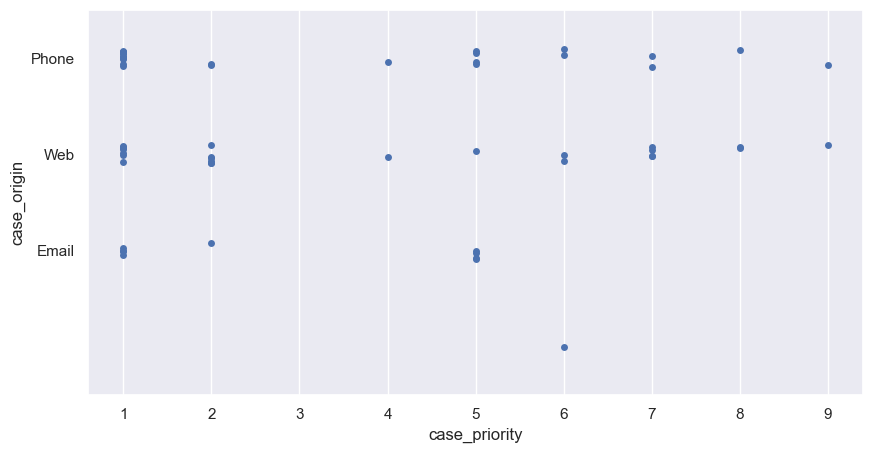

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
query = f"""
    MATCH (a:Account), (cs:Case)
    where a.account_id = cs.account_id
    RETURN
    a.account_name as account_name, 
    a.account_rating as account_rating, 
    a.customer_priority as customer_priority, 
    cs.case_id as case_id, 
    cs.case_origin as case_origin,
    CASE 
      WHEN (a.account_rating = 'Hot' and a.customer_priority = 'High') or cs.priority = 'High' then 1
      WHEN (a.account_rating = 'Warm' and a.customer_priority = 'High')  then 2
      WHEN a.account_rating = 'Cold' and a.customer_priority = 'High' then 3
      WHEN a.account_rating = 'Hot' and a.customer_priority = 'Medium' then 4
      WHEN a.account_rating = 'Warm' and a.customer_priority = 'Medium' then 5
      WHEN a.account_rating = 'Cold' and a.customer_priority = 'Medium' then 6
      WHEN a.account_rating = 'Hot' and a.customer_priority = 'Low' then 7
      WHEN a.account_rating = 'Warm' and a.customer_priority = 'Low' then 8
      WHEN a.account_rating = 'Cold' and a.customer_priority = 'Low' then 9
      ELSE 10
    END AS case_priority
"""
data = run_query(query, graph)
# data = data.groupby(['case_origin','case_priority'])['case_id'].count()
# data = pd.DataFrame(data)
sns.set(rc={'figure.figsize':(10,5)})
sns.stripplot(y = data['case_origin'], x = data['case_priority'])
plt.show()

### List of accounts which have cases whose type is ['Electronic', 'Mechanical', 'Structural', 'Electrical']

In [120]:
#  List of accounts which have cases whose type is ['Electronic', 'Mechanical', 'Structural', 'Electrical']
query = """
MATCH (a:Account)
WHERE EXISTS {
  MATCH (a)-[:has_cases]->(c:Case) where c.case_type in ['Electronic', 'Mechanical', 'Structural', 'Electrical']
}
RETURN a.account_name AS account_name
"""
data = run_query(query, graph)
data

,account_name
0,University of Arizona
1,Grand Hotels & Resorts Ltd
2,Edge Communications
3,Lenarr
4,Veritas
5,Burlington Textiles Corp of America
6,Express Logistics and Transport
7,"United Oil & Gas, Singapore"
8,"United Oil & Gas, UK"
9,Capstone entertainment


### Parent accounts 

In [123]:
# Parent accounts 
query = """
match (a:Account), (p:Account) 
where a.parent_account_id = p.account_id 
return 
a.account_name as account_name, 
p.account_name as parent_account
"""
data = run_query(query, graph)
data

,account_name,parent_account
0,"United Oil & Gas, Singapore","United Oils, Inc"
1,"United Oil & Gas, UK","United Oils, Inc"
2,GenePoint,Pine labs
3,Finacle,JSR finance
4,"Google, Inc","Alphabet, Inc"
5,"GB Financials, EMEA",GB Financials
6,Tantheta,Crowe
7,United Oil & Gas Corp.,"United Oils, Inc"


### Accounts not having opportunities

In [124]:
#  Accounts not having opportunities
query = """
MATCH (a:Account)
WHERE not EXISTS {
  MATCH (a)-[:has_opportunities]->(o:Opportunity) 
}
RETURN a.account_name AS account_name
"""
data = run_query(query, graph)
data

,account_name
0,Sample Account for Entitlements
1,"GB Financials, EMEA"


### Trends of Case Opening and Closure

In [46]:
query = f"""
    match (a:Account), (p:Product), (cs:Case) 
    where cs.product2 = p.product_id 
         and a.account_id = cs.account_id
    return 
          a.account_name as account_name,
          p.product_family as product_family,
          p.product_name as product_name, 
          cs.created_date as created_date,
          cs.closed_date as closed_date,
          count(cs.case_id) as cases 
    order by a.account_name, p.product_family;
"""
data = run_query(query, graph)
data

,account_name,product_family,product_name,created_date,closed_date,cases
0,"Alphabet, Inc",Gear,Gear Box,18/06/2022,27/07/2022,1
1,Apple Graphics,Pump,Pump casing,29/08/2022,12/09/2022,1
2,Burlington Textiles Corp of America,Gear,Gear Box,04/08/2022,19/10/2022,1
3,Burlington Textiles Corp of America,Pump,Pump motor,10/05/2022,17/06/2022,1
4,Burlington Textiles Corp of America,Pump,Pump casing,22/08/2022,27/08/2022,1
5,Burlington Textiles Corp of America,Pump,Pump motor,24/05/2022,01/06/2022,1
6,Capstone entertainment,Battery,Battery Plates,06/06/2022,15/07/2022,1
7,Crowe,Battery,Battery Anode,23/06/2022,30/06/2022,1
8,Crowe,Battery,Battery Anode,18/08/2022,30/09/2022,1
9,Derk Construction,Pump,Pump casing,30/05/2022,14/08/2022,1


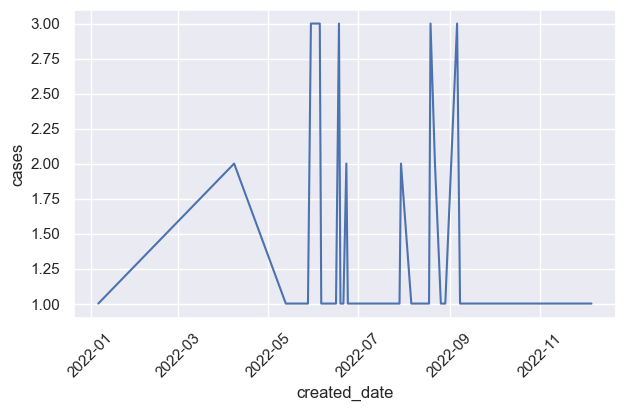

In [54]:
data['created_date'] = pd.to_datetime(data['created_date'],yearfirst = True)
df = data.groupby(['created_date']).sum('cases')
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(7,4)})
sns.lineplot(data=df, x='created_date', y='cases')
plt.xticks(rotation = 45)
plt.show()

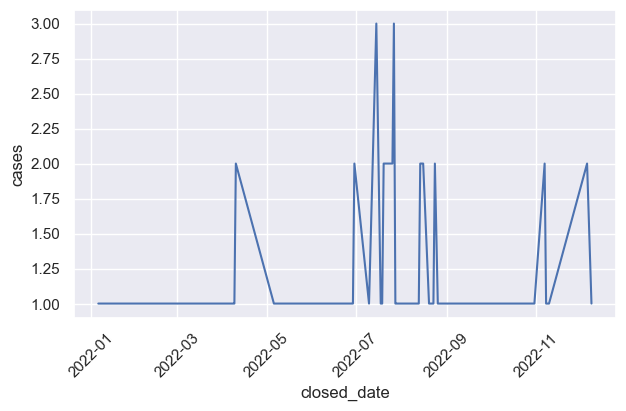

In [55]:
data['closed_date'] = pd.to_datetime(data['closed_date'], yearfirst = True)
df = data.groupby(['closed_date']).sum('cases')
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(7,4)})
sns.lineplot(data=df, x='closed_date', y='cases')
plt.xticks(rotation = 45)
plt.show()

In [82]:
query = """
Match (:Account {account_name: 'Alphabet, Inc'})-[r]->() return type(r)
"""
data = run_query(query, graph)
data

,opportunity
0,Apple Graphics EC-R
1,"Alphabet, Inc EC-R"
2,"Alphabet, Inc EC-U"
3,Alphabet NC


In [87]:
query = """
Match (:Account {account_name: 'Alphabet, Inc'})-[:has_opportunities]->(o:Opportunity) return o.name as opportunity
"""
data = run_query(query, graph)
data

,opportunity
0,Apple Graphics EC-R
1,"Alphabet, Inc EC-R"
2,"Alphabet, Inc EC-U"
3,Alphabet NC


In [86]:
query = """
Match (:Account {account_name: 'United Oil & Gas Corp.'})-[:has_opportunities]->(o:Opportunity)
return o.name as opportunity
"""
data = run_query(query, graph)
data

,opportunity
0,United Oil Refinery Generators
1,United Oil & Gas Corp. NC
2,United Oil Standby Generators
3,United Oil Refinery Generators
4,United Oil Installations
5,United Oil Emergency Generators
6,United Oil Office Portable Generators
7,United Oil Installations
8,United Oil SLA
9,United Oil & Gas Corp. EC-R
